https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from keras import backend as K
from tensorflow.keras.utils import plot_model
import random
from keras.regularizers import L2
import plotly.graph_objs as go
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
# load final clean dataset
df = pd.read_csv('merged_clean_data.csv')

In [3]:
# df.set_index('Date/Time', inplace = True)
print(df[df['provincename'] == 'Quebec'].index.min())
print(df[df['provincename'] == 'Quebec'].index.max())

0
79435


In [4]:
# convert date/time to date time format
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# filter data to remove the rows that doesn't have productivity values
df = df[df['Date/Time'] <= '2021-12-31']

# set date/time as index
df.set_index('Date/Time', inplace = True)

# drop unnecessary columns
sectors_todrop = ['Manufacturing', 'Utilities', 'Educational services', 'Accommodation and food services', 'Other services except public administration',
                  'Public administration', 'Finance and insurance, real estate and rental and leasing', 'Professional scientific and technical services',
                  'Information culture and recreation']

df.drop(columns = sectors_todrop, inplace = True)

# convert 'GeoUID' to string
df['GeoUID'] = df['GeoUID'].astype('str')

# rename columns
df.rename(columns={'Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction': 'Agriculture'}, inplace=True)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85601 entries, 1998-01-01 to 2017-12-01
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   provincename                       85601 non-null  object 
 1   Longitude                          85601 non-null  float64
 2   Latitude                           85601 non-null  float64
 3   Region.Name                        85601 non-null  object 
 4   Construction                       85601 non-null  float64
 5   Transportation and warehousing     85601 non-null  float64
 6   Health care and social assistance  85601 non-null  float64
 7   Agriculture                        85601 non-null  float64
 8   Wholesale trade Retail trade       85601 non-null  float64
 9   Population                         85601 non-null  float64
 10  GeoUID                             85601 non-null  object 
 11  Station Name                       85

## (1) Univariate ##

(1.1) Combination of all 5 provinces

In [6]:
# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = df.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [7]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Construction
Date/Time               
1998-01-31     70.615231
1998-02-28     70.436829
1998-03-31     69.498260
1998-04-30     69.111249
1998-05-31     68.912567


<Axes: title={'center': 'Construction'}, xlabel='Date/Time'>

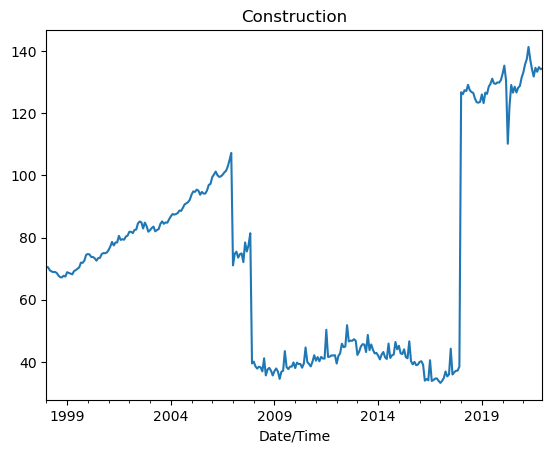

In [8]:
lstm_data = pd.DataFrame(resampled['Construction'])
print(lstm_data.head(5))
lstm_data['Construction'].plot(title = 'Construction')

In [9]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 169.4539031982422
R-squared from the last epoch: -11.264140129089355
Val Mean Squared Error (MSE) from the last epoch: 974.9052734375
Val R-squared from the last epoch: -2.7534286975860596


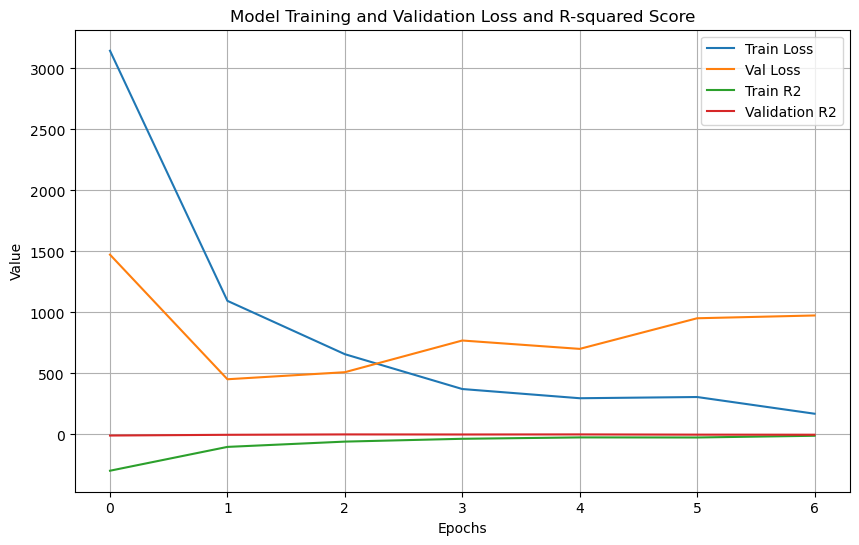

1/1 [==============================] - 0s 33ms/step - loss: 193.9406 - r_squared: -5.4164
MSE and R_squared: [193.9406280517578, -5.416418552398682]
1/1 [==============================] - 1s 557ms/step
Predictions:
[140.23622, 140.72456, 141.7271, 142.34454, 143.02396, 143.36765, 143.71207, 144.11461, 144.17691, 147.00092]
Actual values:
[129.59319, 129.44666, 129.912, 129.83763, 130.62736, 132.63364, 135.29143, 130.49044, 110.18035, 122.29825]


In [10]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='relu', input_shape=(n_steps, n_features), return_sequences=True)))
model.add(Dropout(0.7))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))


def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model

from keras.optimizers import Adam

optimizer = Adam(learning_rate = 0.001, clipnorm=1.0)
model.compile(optimizer = optimizer, 
              loss = 'mse',
              metrics = [r_squared])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 100,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping],
          validation_split = 0.2,
          shuffle = False)

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]
last_epoch_mse_val = history.history['val_loss'][-1]
last_epoch_r_squared_val = history.history['val_r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)
print("Val Mean Squared Error (MSE) from the last epoch:", last_epoch_mse_val)
print("Val R-squared from the last epoch:", last_epoch_r_squared_val)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')
plt.plot(history.history['val_r_squared'], label='Validation R2')

plt.title('Model Training and Validation Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='LSTM Univariate Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.2) Alberta

In [11]:
resampled_AB = df[df['provincename'] == 'Alberta']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_AB.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [12]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Construction
Date/Time               
1998-01-31    111.154667
1998-02-28    100.474174
1998-03-31    109.941311
1998-04-30    113.754728
1998-05-31    114.764194


<Axes: title={'center': 'Construction'}, xlabel='Date/Time'>

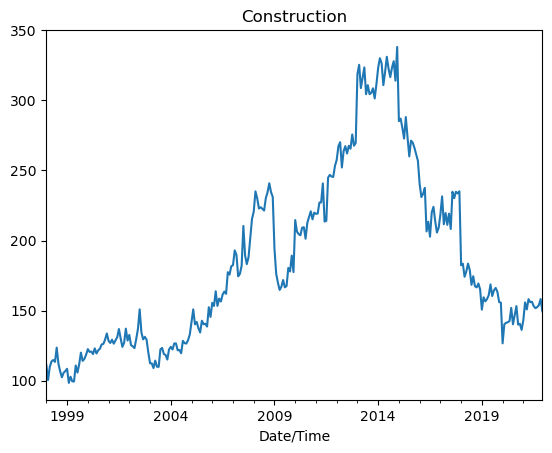

In [13]:
lstm_data = pd.DataFrame(resampled['Construction'])
print(lstm_data.head(5))
lstm_data['Construction'].plot(title = 'Construction')

In [14]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 116.00056457519531
R-squared from the last epoch: 0.9728100299835205


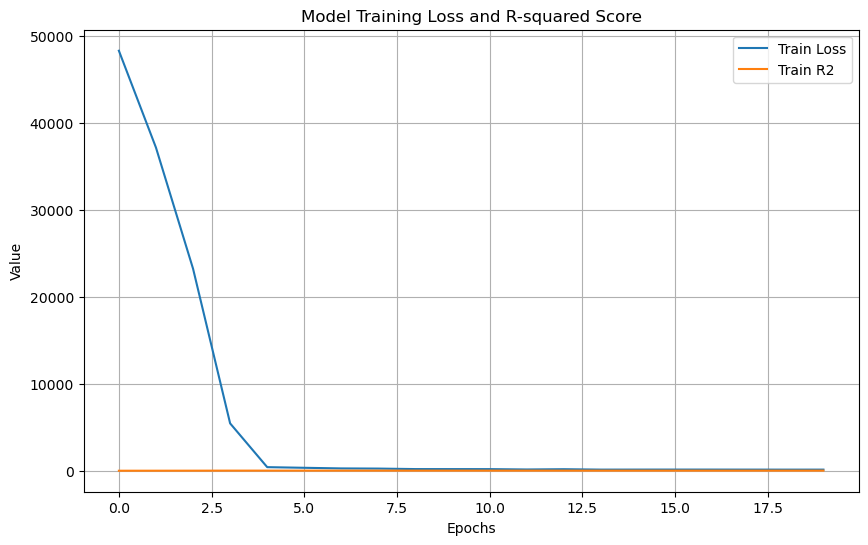

1/1 [==============================] - 0s 440ms/step - loss: 63.7774 - r_squared: 0.2242
MSE and R_squared: [63.77739334106445, 0.22421616315841675]
1/1 [==============================] - 0s 227ms/step
Predictions:
[163.29868, 166.14758, 167.0948, 165.6773, 158.22496, 154.84575, 134.27061, 135.37889, 136.63702, 140.68692]
Actual values:
[164.48192, 166.2004, 163.3335, 156.1118, 155.67785, 126.65211, 140.25585, 141.28372, 141.70226, 142.50345]


In [15]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='Alberta: LSTM Univariate Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.3) Bristish Columbia

In [16]:
resampled_BC = df[df['provincename'] == 'British Columbia']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_BC.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [17]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Construction
Date/Time               
1998-01-31     49.811125
1998-02-28     51.370275
1998-03-31     46.995329
1998-04-30     42.590994
1998-05-31     44.012357


<Axes: title={'center': 'Construction'}, xlabel='Date/Time'>

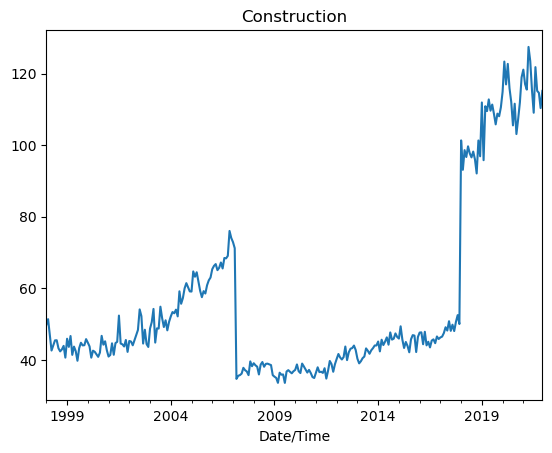

In [18]:
lstm_data = pd.DataFrame(resampled['Construction'])
print(lstm_data.head(5))
lstm_data['Construction'].plot(title = 'Construction')

In [19]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00
Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


In [20]:
# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Mean Squared Error (MSE) from the last epoch: 22.60250473022461
R-squared from the last epoch: 0.9045260548591614


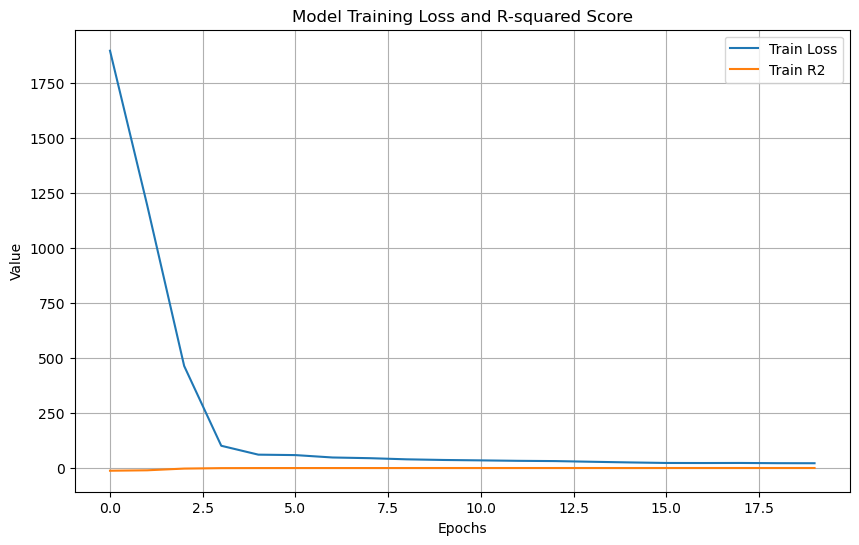

1/1 [==============================] - 0s 349ms/step - loss: 89.3984 - r_squared: -1.4543
MSE and R_squared: [89.39838409423828, -1.4542675018310547]
1/1 [==============================] - 0s 246ms/step
Predictions:
[108.45266, 100.727455, 105.56459, 104.71938, 106.65101, 107.85263, 111.10267, 115.42942, 98.11163, 117.93908]
Actual values:
[108.7402, 105.827102, 108.82455, 108.09422, 110.58089, 114.92379, 123.38149, 116.99828, 122.73096, 115.9214]


In [21]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='British Columbia: LSTM Univariate Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.4) Ontario

In [22]:
resampled_ON = df[df['provincename'] == 'Ontario']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_ON.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [23]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Construction', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Construction
Date/Time               
1998-01-31    186.461540
1998-02-28    187.225972
1998-03-31    179.361773
1998-04-30    185.388467
1998-05-31    172.052059


<Axes: title={'center': 'Construction'}, xlabel='Date/Time'>

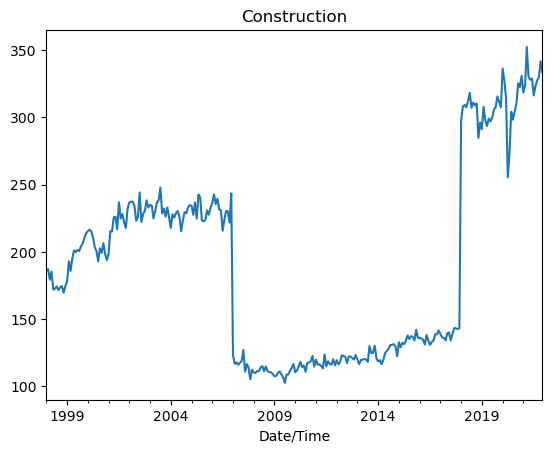

In [24]:
lstm_data = pd.DataFrame(resampled['Construction'])
print(lstm_data.head(5))
lstm_data['Construction'].plot(title = 'Construction')

In [25]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 223.26065063476562
R-squared from the last epoch: 0.942187488079071


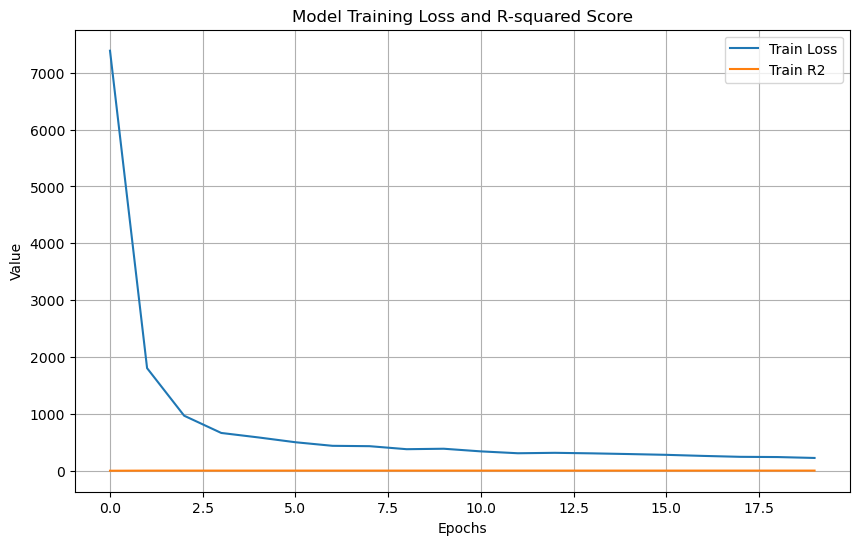

1/1 [==============================] - 0s 280ms/step - loss: 406.2127 - r_squared: -0.1284
MSE and R_squared: [406.21270751953125, -0.12841975688934326]
1/1 [==============================] - 0s 208ms/step
Predictions:
[295.60843, 300.15402, 300.64972, 305.0533, 309.0472, 304.7966, 313.59067, 330.3271, 330.89908, 272.31577]
Actual values:
[305.95578, 307.66469, 315.69955, 311.7051, 307.4864, 336.4256, 327.64991, 314.2706, 255.4962, 273.69154]


In [26]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='Ontario: LSTM Univariate Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.5) Quebec

In [27]:
resampled_QC = df[df['provincename'] == 'Quebec']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_QC.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [28]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Construction
Date/Time               
1998-01-31     44.009793
1998-02-28     47.135313
1998-03-31     48.664697
1998-04-30     47.979613
1998-05-31     52.589607


<Axes: title={'center': 'Construction'}, xlabel='Date/Time'>

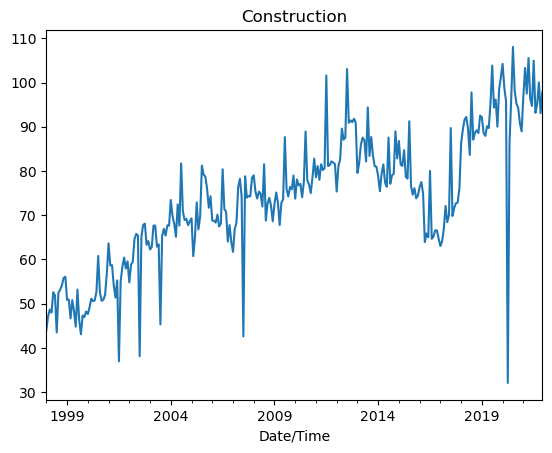

In [29]:
lstm_data = pd.DataFrame(resampled['Construction'])
print(lstm_data.head(5))
lstm_data['Construction'].plot(title = 'Construction')

In [30]:
# Initialize an empty dictionary to store DataFrames for each column
resampled_dataframes = {}

# Iterate over each column name
for column in columns:
    # Get the data for the current column
    column_data = resampled[column]
    
    # Convert to DataFrame and store in the dictionary
    column_data_df = pd.DataFrame(column_data)
    resampled_dataframes[column] = column_data_df
    
    # Display the first 14 rows
    print(f"Data for column '{column}':")
    print(column_data_df.head(3))

Data for column 'Construction':
            Construction
Date/Time               
1998-01-31     44.009793
1998-02-28     47.135313
1998-03-31     48.664697
Data for column 'Transportation and warehousing':
            Transportation and warehousing
Date/Time                                 
1998-01-31                       26.979831
1998-02-28                       28.244141
1998-03-31                       29.007407
Data for column 'Health care and social assistance':
            Health care and social assistance
Date/Time                                    
1998-01-31                          76.390411
1998-02-28                          78.896252
1998-03-31                          79.649614
Data for column 'Agriculture':
            Agriculture
Date/Time              
1998-01-31    26.874227
1998-02-28    26.326112
1998-03-31    26.940388
Data for column 'Wholesale trade Retail trade':
            Wholesale trade Retail trade
Date/Time                               
1998-01-31    

In [31]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

In [32]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 37.00550842285156
R-squared from the last epoch: 0.7543078064918518


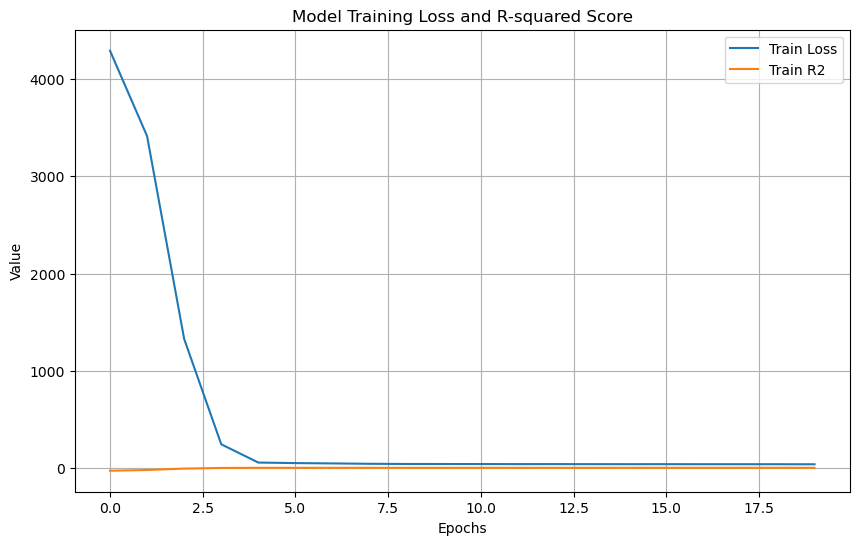

1/1 [==============================] - 0s 361ms/step - loss: 203.1931 - r_squared: -0.2323
MSE and R_squared: [203.19305419921875, -0.23230338096618652]
1/1 [==============================] - 0s 231ms/step
Predictions:
[94.55314, 93.755974, 94.37045, 93.01059, 94.86879, 96.91971, 99.42634, 98.373245, 97.40164, 107.288414]
Actual values:
[94.33691, 96.133364, 90.01287, 98.55065, 101.20411, 104.23143, 98.87454, 95.716637, 32.06209, 86.280985]


In [33]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='Quebec: LSTM Univariate Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.6) Saskatchewan

In [34]:
resampled_SK = df[df['provincename'] == 'Saskatchewan']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_SK.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [35]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Construction', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Construction
Date/Time               
1998-01-31      1.955521
1998-02-28      1.973519
1998-03-31      1.815502
1998-04-30      1.966323
1998-05-31      1.895740


<Axes: title={'center': 'Construction'}, xlabel='Date/Time'>

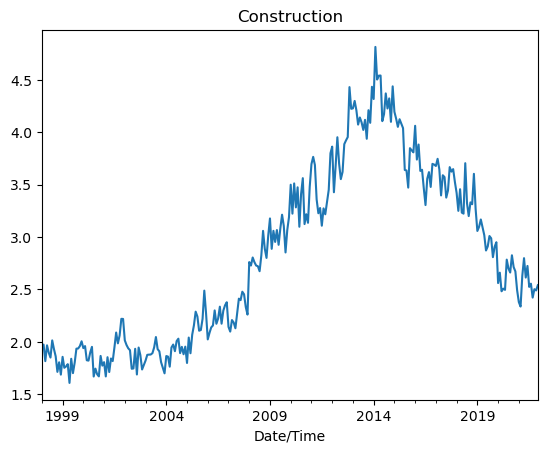

In [36]:
lstm_data = pd.DataFrame(resampled['Construction'])
print(lstm_data.head(5))
lstm_data['Construction'].plot(title = 'Construction')

In [37]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 0.03203456476330757
R-squared from the last epoch: 0.9572567939758301


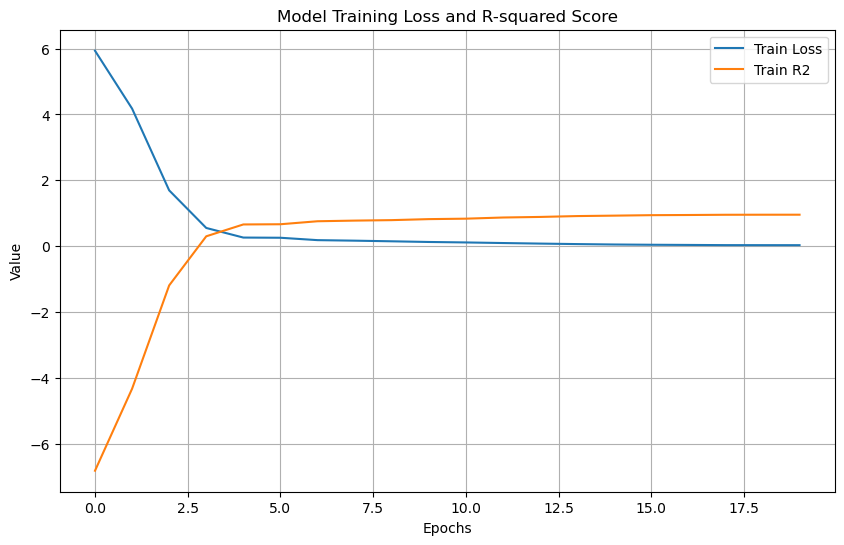

1/1 [==============================] - 0s 279ms/step - loss: 0.0302 - r_squared: 0.0520
MSE and R_squared: [0.030160650610923767, 0.05199635028839111]
1/1 [==============================] - 0s 229ms/step
Predictions:
[3.0129578, 2.9995182, 2.9959958, 2.965345, 2.9369783, 2.9248118, 2.8740604, 2.822537, 2.7385802, 2.6571646]
Actual values:
[3.0094363, 2.9876984, 2.8078659, 2.907217, 2.9502564, 2.5605945, 2.6595916, 2.482223, 2.5073272, 2.4957452]


In [38]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='Saskatchewan: LSTM Univariate Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

## (2) Multivariate ##

In [39]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (15, 6)
mpl.rcParams['axes.grid'] = False

In [40]:
columns = [
    'Construction',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)'
]

(2.1) Combination of all 5 provinces

In [41]:
# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = df.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [42]:
resampled = resampled[columns]
resampled.head()


,Construction,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,70.615231,-3.476795,-11.475936,-7.483320,7.229147,-25.824194,62.171390,30.895640,102.139782,16.223433,0.498638,1.321526
1998-02-28,70.436829,2.335362,-6.219163,-1.968022,8.785487,-16.149888,43.465123,9.188011,57.897275,14.411444,0.370572,1.049046
1998-03-31,69.498260,4.270940,-5.059074,-0.388330,15.420638,-16.974551,43.057493,17.122616,65.206267,5.264305,0.326975,1.237057
1998-04-30,69.111249,12.866301,0.774230,6.834755,23.147497,-4.935786,34.318699,2.743902,39.689702,0.143631,0.382114,1.281843
1998-05-31,68.912567,19.732610,6.950949,13.355348,27.606341,0.251378,48.026216,0.022973,53.502432,0.000000,0.491892,1.432432


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

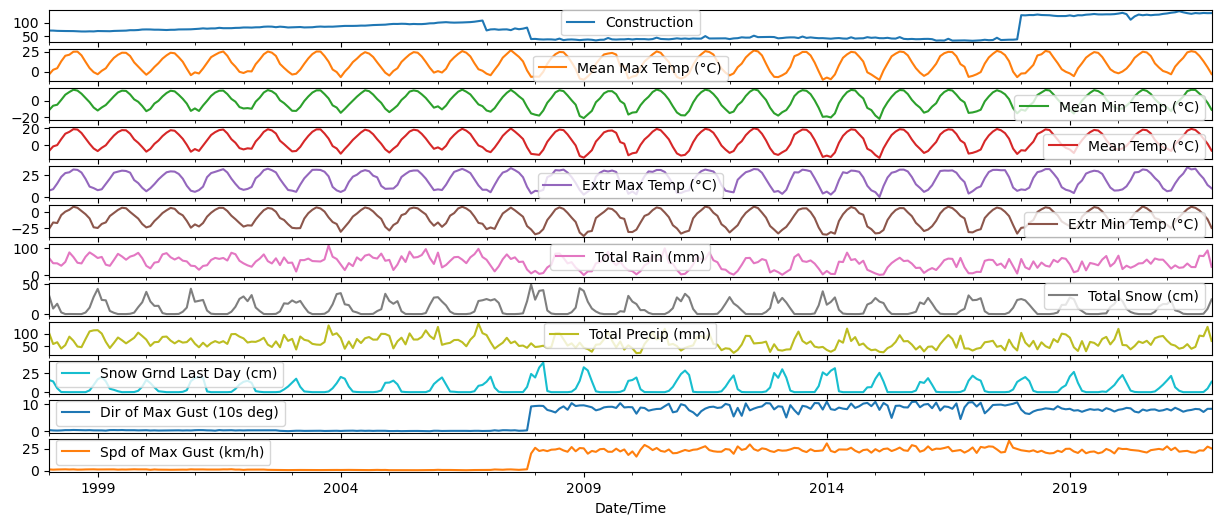

In [43]:
resampled[[
    'Construction',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [44]:
# split into train and test
train_end_date = '2014-12-31'
test_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[(resampled.index > train_end_date) & (resampled.index <= test_end_date)]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2014-12-31 00:00:00
(204, 12)
Test data:
2015-01-31 00:00:00
2018-12-31 00:00:00
(48, 12)


In [45]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)

[ 70.61523127  -3.47679494 -11.47593552  -7.4833201    7.22914743
 -25.82419367  62.17138965  30.89564033 102.13978202  16.22343324
   0.4986376    1.32152589]
(204, 12)
[ 45.20798868  -6.93525431 -18.02150148 -12.41078558   5.33613506
 -32.71309274   5.99567568  26.73081081  35.56378378  18.04864865
  10.91351351  24.27567568]
(48, 12)


In [46]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i-n_past,0])
    return np.array(dataX),np.array(dataY)    

In [47]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (203, 1, 11)
y_train: (203,)
After reshape:
X_train: (203, 11)
y_train: (203, 1)
Before reshape:
X_test: (47, 1, 11)
y_test: (47,)
After reshape:
X_test: (47, 11)
y_test: (47, 1)


In [48]:
train_data_array[0]

array([ 70.61523127,  -3.47679494, -11.47593552,  -7.4833201 ,
         7.22914743, -25.82419367,  62.17138965,  30.89564033,
       102.13978202,  16.22343324,   0.4986376 ,   1.32152589])

In [49]:
X_train[0]

array([ -3.47679494, -11.47593552,  -7.4833201 ,   7.22914743,
       -25.82419367,  62.17138965,  30.89564033, 102.13978202,
        16.22343324,   0.4986376 ,   1.32152589])

In [50]:
y_train[0]

array([70.61523127])

In [51]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.2883016 -1.1535624 -1.228502  -1.3083715 -1.29608    0.632706
  1.7009449  1.5245554  1.1311881 -0.7845985 -0.7965283]
X_train_scaled: (203, 11)
y_train_scaled: [[0.2476315]
 [0.2393712]
 [0.1959145]
 [0.1779954]
 [0.1687962]]
y_train_scaled: (203, 1)
X_test_scaled: [-1.5464153 -1.7440852 -1.6452251 -1.5012686 -1.6764014 -1.5506973
  1.767274  -0.9832672  1.5672962  1.3181803  0.1775014]
X_test_scaled: (47, 11)
y_test_scaled: [[-0.3638667]
 [-0.4287002]
 [-0.4349104]
 [-0.394118 ]
 [-0.4616069]]
y_test_scaled: (47, 1)


In [52]:
y_train_scaled

array([[ 0.2476315],
       [ 0.2393712],
       [ 0.1959145],
       [ 0.1779954],
       [ 0.1687962],
       [ 0.1704098],
       [ 0.1552943],
       [ 0.1172768],
       [ 0.0927101],
       [ 0.0893303],
       [ 0.1142028],
       [ 0.101816 ],
       [ 0.1664617],
       [ 0.1565178],
       [ 0.1466126],
       [ 0.135001 ],
       [ 0.1830163],
       [ 0.1975185],
       [ 0.2168054],
       [ 0.2377668],
       [ 0.3092933],
       [ 0.3060916],
       [ 0.3400769],
       [ 0.4241903],
       [ 0.4381633],
       [ 0.4303141],
       [ 0.3930957],
       [ 0.3934001],
       [ 0.373837 ],
       [ 0.3387102],
       [ 0.3761853],
       [ 0.3805038],
       [ 0.4361655],
       [ 0.4513584],
       [ 0.4496663],
       [ 0.4603317],
       [ 0.4960366],
       [ 0.5486395],
       [ 0.6174635],
       [ 0.5653481],
       [ 0.6084358],
       [ 0.6107792],
       [ 0.7083375],
       [ 0.6479873],
       [ 0.6580596],
       [ 0.6507546],
       [ 0.6980118],
       [ 0.71

In [53]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (203, 11)
X_test: (47, 11)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1, 128)            71680     
                                                                 
 dropout_1 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_8 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 203393 (794.50 KB)
Trainable params: 203393 (794.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean Squ

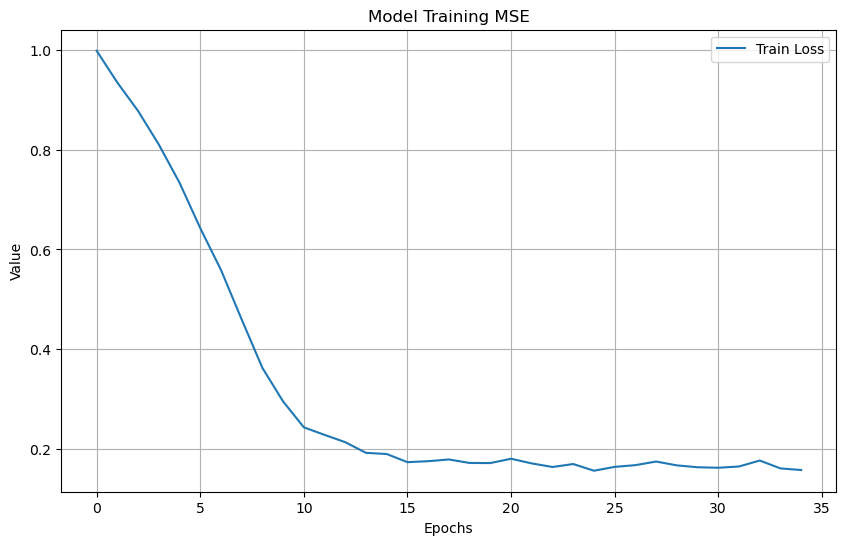

In [54]:
from keras.optimizers import Adam

# Model architecture
# model = Sequential()
# model.add(LSTM(256, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(64))
# model.add(Dropout(0.5))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse')

model.summary()

early_stopping = EarlyStopping(monitor='loss', patience=10)

# fit model

history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')


plt.title('Model Training MSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE", loss)

2/2 [==============================] - 1s 10ms/step - loss: 0.7520
MSE 0.7519752979278564


In [56]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 0s/step
train_predict: (203, 1)
test_predict: (47, 1)


In [57]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_train, train_predict)
print("Train R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='5 Provinces: LSTM Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (203, 1)
y_train_scaled_inversed: (203, 1)
Train Mean Absolute Error: 6.425289423007065
Train Root Mean Squared Error: 8.197514080228304
Train R-squared: 0.8559388073507996


In [58]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test 
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_test, test_predict)
print("Test R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='5 Provinces: LSTM Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (47, 1)
y_test_scaled_inversed: (47, 1)
Test Mean Absolute Error: 26.979447710235647
Test Root Mean Squared Error: 32.452452001522495
Test R-squared: 0.24802472313819102


(2.2) Alberta

In [59]:
resampled_AB = df[df['provincename'] == 'Alberta']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_AB.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()


,Construction,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,111.154667,-9.174123,-19.446359,-14.327202,7.285181,-36.542816,0.085185,16.261111,15.305556,7.611111,1.388889,2.129630
1998-02-28,100.474174,1.726643,-9.481329,-3.892085,9.294639,-18.085026,0.059259,2.807407,2.512963,6.018519,0.240741,0.685185
1998-03-31,109.941311,2.130065,-9.171270,-3.530172,13.286094,-24.753519,1.240741,23.177778,21.712963,2.666667,0.907407,2.814815
1998-04-30,113.754728,13.155375,-0.826884,6.184374,22.869606,-6.995261,14.363636,5.376364,20.041818,0.000000,0.563636,3.236364
1998-05-31,114.764194,20.054474,4.686848,12.396424,27.039213,-1.883615,48.781818,0.000000,49.996364,0.000000,1.636364,4.363636


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

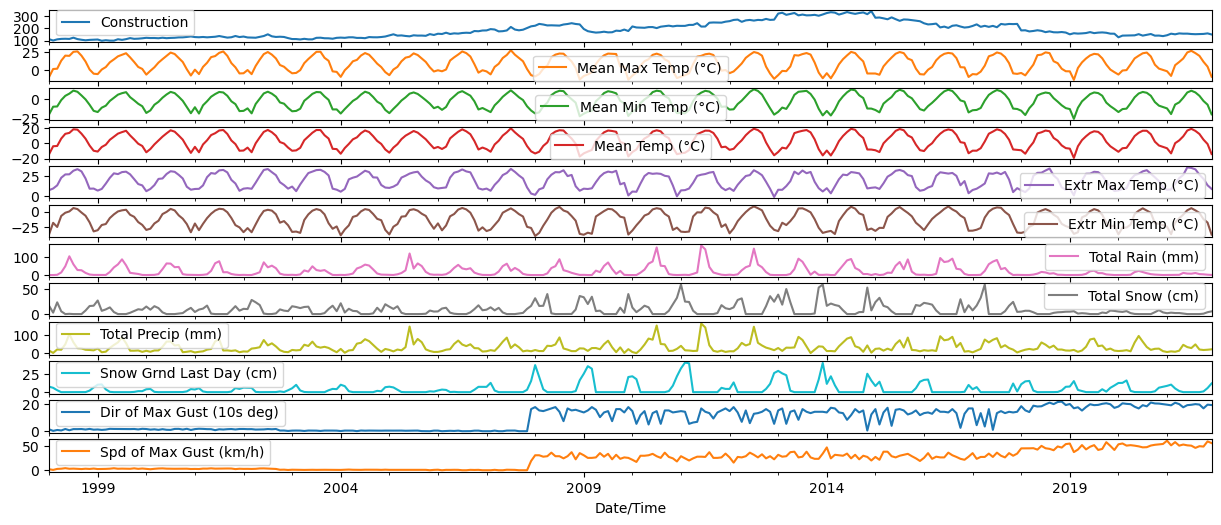

In [60]:
resampled[[
    'Construction',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [61]:
# split into train and test
train_end_date = '2014-12-31'
test_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[(resampled.index > train_end_date) & (resampled.index <= test_end_date)]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2014-12-31 00:00:00
(204, 12)
Test data:
2015-01-31 00:00:00
2018-12-31 00:00:00
(48, 12)


In [62]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[ 1.1115467e+02 -9.1741231e+00 -1.9446359e+01 -1.4327202e+01
  7.2851810e+00 -3.6542816e+01  8.5185185e-02  1.6261111e+01
  1.5305556e+01  7.6111111e+00  1.3888889e+00  2.1296296e+00]
(204, 12)
[285.1464483  -4.45      -13.8        -9.15       10.75      -31.05
   5.6        23.55       24.7         8.5        16.5        28.       ]
(48, 12)


In [63]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i - n_past,0])
    return np.array(dataX),np.array(dataY)    

In [64]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (203, 1, 11)
y_train: (203,)
After reshape:
X_train: (203, 11)
y_train: (203, 1)
Before reshape:
X_test: (47, 1, 11)
y_test: (47,)
After reshape:
X_test: (47, 11)
y_test: (47, 1)


In [65]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.6826387 -1.7324872 -1.7100531 -1.3004064 -1.7700536 -0.7697155
  0.5752101 -0.6544127  0.3521982 -0.6957756 -0.7941258]
X_train_scaled: (203, 11)
y_train_scaled: [[-1.032373 ]
 [-1.1902897]
 [-1.0503131]
 [-0.9939297]
 [-0.9790042]]
y_train_scaled: (203, 1)
X_test_scaled: [-1.2518705 -1.2792955 -1.2710203 -0.9567904 -1.490415  -0.6007109
  1.1776488 -0.4589515  0.9104309  0.4532999 -0.6724978]
X_test_scaled: (47, 11)
y_test_scaled: [[1.7176714]
 [1.7690746]
 [1.5836937]
 [1.369206 ]
 [1.8003491]]
y_test_scaled: (47, 1)


In [66]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (203, 11)
X_test: (47, 11)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1, 128)            71680     
                                                                 
 dropout_3 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_10 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 203393 (794.50 KB)
Trainable params: 203393 (794.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean Squ

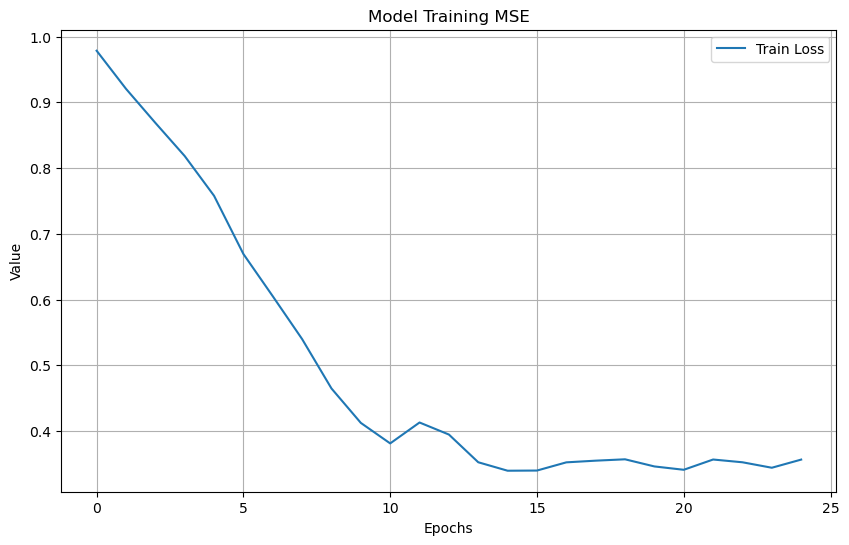

In [67]:
from keras.optimizers import Adam

# Model architecture
# model = Sequential()
# model.add(LSTM(256, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(64))
# model.add(Dropout(0.5))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse')

model.summary()

early_stopping = EarlyStopping(monitor='loss', patience=10)

# fit model

history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')


plt.title('Model Training MSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE", loss)

2/2 [==============================] - 1s 10ms/step - loss: 2.2119
MSE 2.2118990421295166


In [69]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 17ms/step
train_predict: (203, 1)
test_predict: (47, 1)


In [70]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_train, train_predict)
print("Train R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='Alberta: LSTM Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (203, 1)
y_train_scaled_inversed: (203, 1)
Train Mean Absolute Error: 30.794145008037493
Train Root Mean Squared Error: 38.52709749885998
Train R-squared: 0.6755065448257536


In [71]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test 
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_test, test_predict)
print("Test R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='Alberta: LSTM Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (47, 1)
y_test_scaled_inversed: (47, 1)
Test Mean Absolute Error: 42.54133275354419
Test Root Mean Squared Error: 52.99880448268208
Test R-squared: -1.211899146617006


(2.3) Bristish Columbia

In [72]:
resampled_BC = df[df['provincename'] == 'British Columbia']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_BC.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()

,Construction,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,49.811125,1.668112,-4.154257,-1.238191,9.430297,-17.129487,136.186364,33.692424,191.862121,11.113636,0.234848,1.409091
1998-02-28,51.370275,5.952033,-0.389383,2.724369,10.398405,-6.490740,100.753030,9.244697,122.815152,12.719697,0.234848,1.431818
1998-03-31,46.995329,8.189304,0.355152,4.292350,14.542492,-6.209205,70.272727,7.814394,90.611364,7.219697,0.234848,0.969697
1998-04-30,42.590994,13.038331,2.417762,7.737061,23.675751,-2.323696,45.203030,2.137879,53.328788,0.075758,0.234848,0.954545
1998-05-31,44.012357,18.087071,7.296346,12.687342,26.394613,2.266207,50.971429,0.001504,63.715038,0.000000,0.210526,0.759398


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

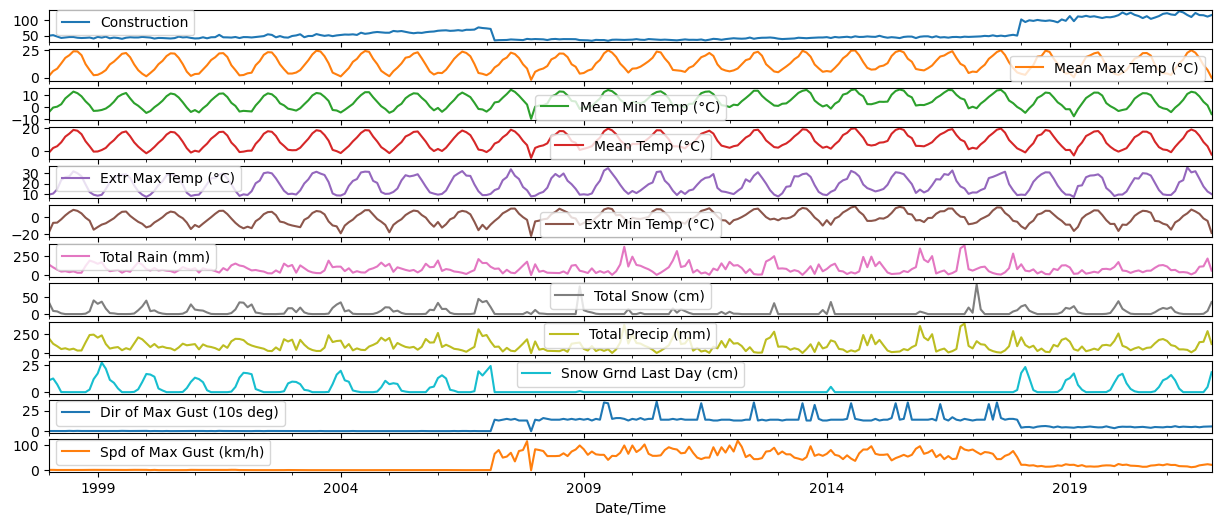

In [73]:
resampled[[
    'Construction',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [74]:
# split into train and test
train_end_date = '2014-12-31'
test_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[(resampled.index > train_end_date) & (resampled.index <= test_end_date)]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2014-12-31 00:00:00
(204, 12)
Test data:
2015-01-31 00:00:00
2018-12-31 00:00:00
(48, 12)


In [75]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[ 49.8111247   1.6681116  -4.1542568  -1.2381905   9.430297  -17.1294871
 136.1863636  33.6924242 191.8621212  11.1136364   0.2348485   1.4090909]
(204, 12)
[ 45.9344633   7.6         3.3         5.5        12.5        -3.4
 116.8         0.        116.8         0.         15.         65.       ]
(48, 12)


In [76]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)    

In [77]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (203, 1, 11)
y_train: (203,)
After reshape:
X_train: (203, 11)
y_train: (203, 1)
Before reshape:
X_test: (47, 1, 11)
y_test: (47,)
After reshape:
X_test: (47, 11)
y_test: (47, 1)


In [78]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.5751278 -1.6301398 -1.6094629 -1.2470013 -2.3188542  0.927755
  2.3789508  1.3828037  1.4007111 -0.8081919 -0.8408499]
X_train_scaled: (203, 11)
y_train_scaled: [[ 0.5954091]
 [ 0.1294562]
 [-0.3396267]
 [-0.1882446]
 [-0.0374081]]
y_train_scaled: (203, 1)
X_test_scaled: [-0.9724927 -0.6234884 -0.820507  -1.0452681 -0.7594823  0.2577639
 -0.3508397  0.1556163 -0.2872467  0.0944318  0.5383258]
X_test_scaled: (47, 11)
y_test_scaled: [[-0.4597447]
 [-0.6266345]
 [-0.7319135]
 [-0.6566923]
 [-0.7067916]]
y_test_scaled: (47, 1)


In [79]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (203, 11)
X_test: (47, 11)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 1, 128)            71680     
                                                                 
 dropout_5 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_12 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 203393 (794.50 KB)
Trainable params: 203393 (794.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean Squ

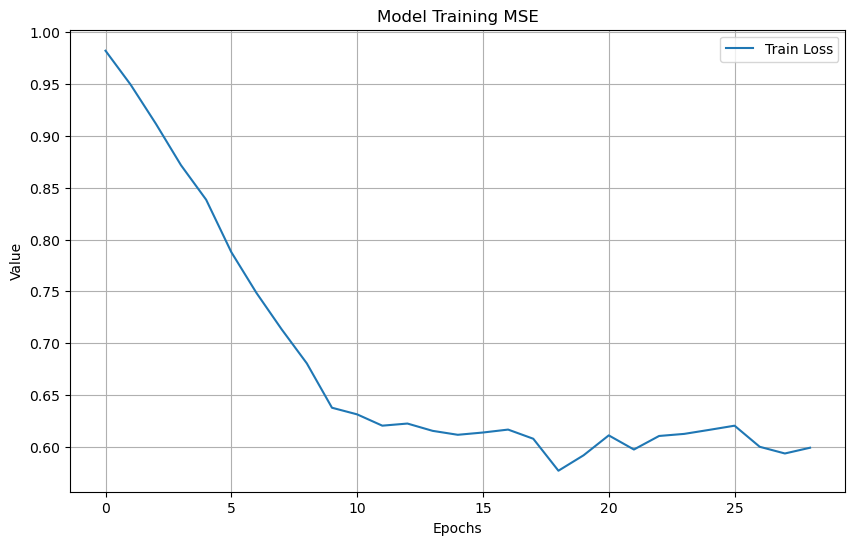

In [80]:
from keras.optimizers import Adam

# Model architecture
# model = Sequential()
# model.add(LSTM(256, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(64))
# model.add(Dropout(0.5))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse')

model.summary()

early_stopping = EarlyStopping(monitor='loss', patience=10)

# fit model

history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')


plt.title('Model Training MSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [81]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE", loss)

2/2 [==============================] - 1s 8ms/step - loss: 0.4445
MSE 0.44448068737983704


In [82]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 14ms/step
train_predict: (203, 1)
test_predict: (47, 1)


In [83]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_train, train_predict)
print("Train R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='British Columbia: LSTM Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (203, 1)
y_train_scaled_inversed: (203, 1)
Train Mean Absolute Error: 5.507718669984496
Train Root Mean Squared Error: 7.180595475718731
Train R-squared: 0.4151299212327939


In [84]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test 
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_test, test_predict)
print("Test R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='British Columbia: LSTM Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (47, 1)
y_test_scaled_inversed: (47, 1)
Test Mean Absolute Error: 11.604460637620788
Test Root Mean Squared Error: 14.838596513399217
Test R-squared: 0.555519359616651


(2.4) Ontario

In [85]:
resampled_ON = df[df['provincename'] == 'Ontario']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_ON.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()

,Construction,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,186.461540,-1.335346,-8.817714,-5.073900,8.603917,-21.208080,51.952941,32.298039,90.741176,12.921569,0.450980,1.098039
1998-02-28,187.225972,2.038014,-6.539054,-2.244561,8.939422,-17.776302,25.582353,4.156863,31.288235,4.627451,0.607843,1.019608
1998-03-31,179.361773,4.565397,-4.241625,0.163845,21.541639,-17.859510,49.825490,25.756863,77.333333,0.843137,0.078431,1.156863
1998-04-30,185.388467,13.340110,1.406302,7.379227,21.728006,-4.285085,39.958824,0.517647,42.747059,0.000000,0.411765,1.019608
1998-05-31,172.052059,21.705825,9.513872,15.624558,29.795932,2.421586,42.966667,0.031373,47.249020,0.000000,0.470588,1.352941


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

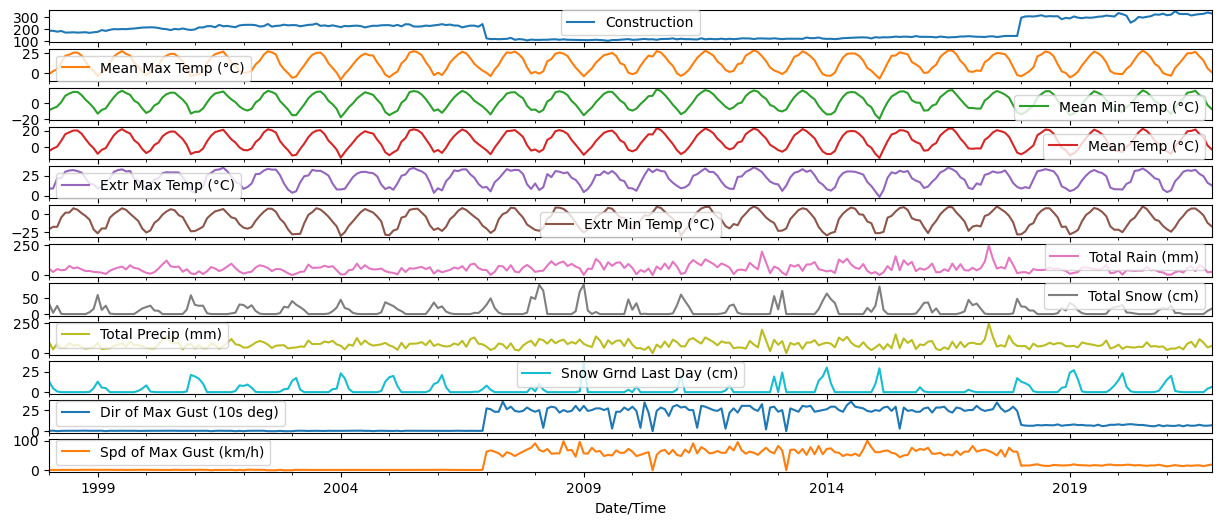

In [86]:
resampled[[
    'Construction',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [87]:
# split into train and test
train_end_date = '2014-12-31'
test_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[(resampled.index > train_end_date) & (resampled.index <= test_end_date)]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2014-12-31 00:00:00
(204, 12)
Test data:
2015-01-31 00:00:00
2018-12-31 00:00:00
(48, 12)


In [88]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[186.4615398  -1.335346   -8.8177137  -5.0739      8.6039171 -21.2080801
  51.9529412  32.2980392  90.7411765  12.9215686   0.4509804   1.0980392]
(204, 12)
[132.8887495  -2.6       -14.8        -8.8         5.2       -26.9
  24.6        26.         47.4        10.         25.         61.       ]
(48, 12)


In [89]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i- n_past,0])
    return np.array(dataX),np.array(dataY)    

In [90]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (203, 1, 11)
y_train: (203,)
After reshape:
X_train: (203, 11)
y_train: (203, 1)
Before reshape:
X_test: (47, 1, 11)
y_test: (47,)
After reshape:
X_test: (47, 11)
y_test: (47, 1)


In [91]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.3296665 -1.1751887 -1.2572338 -1.4286801 -1.2166938 -0.134898
  1.1176424  0.6131522  1.6094368 -0.8631223 -0.8895057]
X_train_scaled: (203, 11)
y_train_scaled: [[0.3041783]
 [0.3187993]
 [0.168384 ]
 [0.2836541]
 [0.0285741]]
y_train_scaled: (203, 1)
X_test_scaled: [-1.4744108 -1.7602623 -1.6256451 -1.7361759 -1.641118  -0.846613
  0.8663017 -0.7427338  1.412211   0.4440937  0.4863386]
X_test_scaled: (47, 11)
y_test_scaled: [[-0.6025726]
 [-0.6554086]
 [-0.6084784]
 [-0.6231829]
 [-0.5927067]]
y_test_scaled: (47, 1)


In [92]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (203, 11)
X_test: (47, 11)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 1, 128)            71680     
                                                                 
 dropout_7 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_14 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 203393 (794.50 KB)
Trainable params: 203393 (794.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean Squ

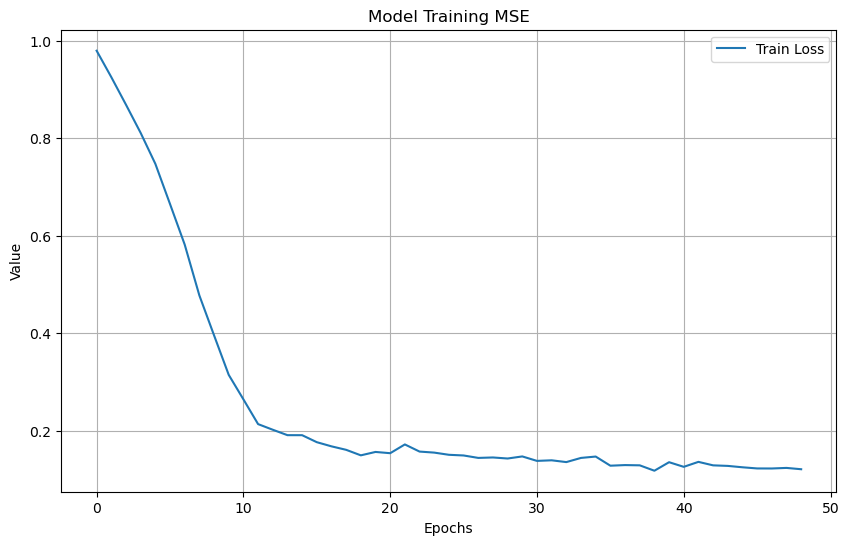

In [93]:
from keras.optimizers import Adam

# Model architecture
# model = Sequential()
# model.add(LSTM(256, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(64))
# model.add(Dropout(0.5))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse')

model.summary()

early_stopping = EarlyStopping(monitor='loss', patience=10)

# fit model

history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')


plt.title('Model Training MSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [94]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE", loss)

2/2 [==============================] - 1s 11ms/step - loss: 0.1157
MSE 0.11569004505872726


In [95]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 8ms/step
train_predict: (203, 1)
test_predict: (47, 1)


In [96]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_train, train_predict)
print("Train R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='Ontario: LSTM Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (203, 1)
y_train_scaled_inversed: (203, 1)
Train Mean Absolute Error: 12.110687647211236
Train Root Mean Squared Error: 16.299558221120144
Train R-squared: 0.9028088696579248


In [97]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test 
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_test, test_predict)
print("Test R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='Ontario: LSTM Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (47, 1)
y_test_scaled_inversed: (47, 1)
Test Mean Absolute Error: 19.08598526439988
Test Root Mean Squared Error: 24.588888764481663
Test R-squared: 0.8843099646593918


(2.5) Quebec

In [98]:
resampled_QC = df[df['provincename'] == 'Quebec']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_QC.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()

,Construction,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,44.009793,-4.552563,-13.994682,-9.287824,5.741158,-29.829489,25.681176,43.316471,69.741176,35.976471,0.364706,0.847059
1998-02-28,47.135313,-0.896600,-11.473360,-6.188613,7.167492,-25.858277,14.797647,16.928235,32.250588,31.517647,0.329412,0.670588
1998-03-31,48.664697,2.044358,-7.643261,-2.797791,15.422714,-22.235325,45.856471,28.203529,75.307059,7.600000,0.341176,0.694118
1998-04-30,47.979613,11.654923,-0.400211,5.643657,22.055794,-6.318341,38.970588,4.340000,43.837647,0.505882,0.317647,0.658824
1998-05-31,52.589607,20.997578,7.887234,14.470646,28.402177,-0.216450,57.038824,0.000000,57.442353,0.000000,0.105882,0.717647


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

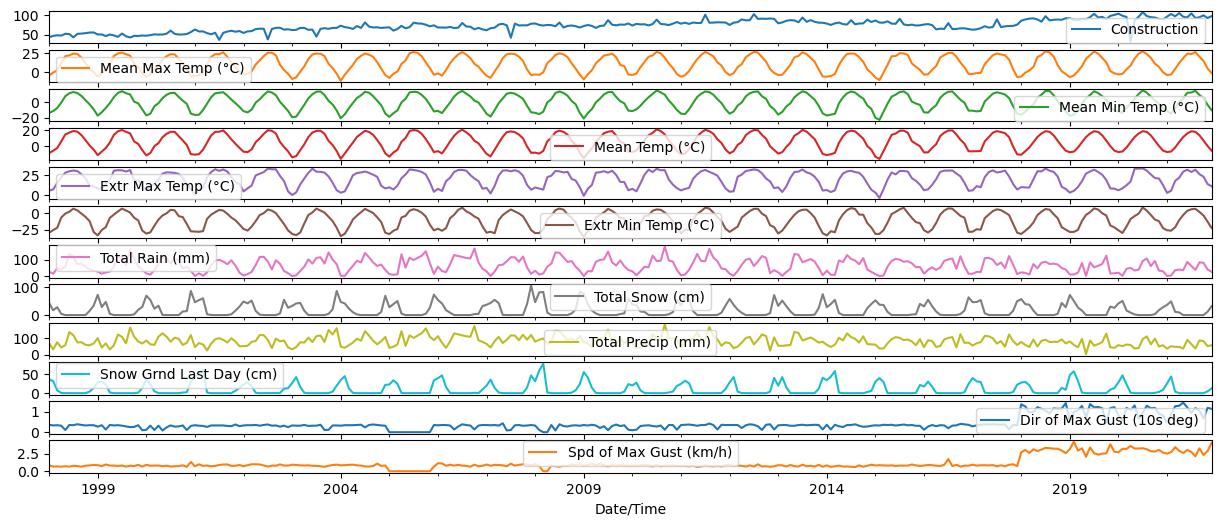

In [99]:
resampled[[
    'Construction',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [100]:
# split into train and test
train_end_date = '2014-12-31'
test_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[(resampled.index > train_end_date) & (resampled.index <= test_end_date)]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2014-12-31 00:00:00
(204, 12)
Test data:
2015-01-31 00:00:00
2018-12-31 00:00:00
(48, 12)


In [101]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[ 44.0097934  -4.5525631 -13.9946817  -9.2878244   5.7411585 -29.8294891
  25.6811765  43.3164706  69.7411765  35.9764706   0.3647059   0.8470588]
(204, 12)
[ 86.7861227  -7.5620562 -20.2226006 -13.720897    3.3433728 -31.6792533
  11.3325301  52.6204819  60.9192771  30.          0.3373494   0.8313253]
(48, 12)


In [102]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i- n_past,0])
    return np.array(dataX),np.array(dataY)    

In [103]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (203, 1, 11)
y_train: (203,)
After reshape:
X_train: (203, 11)
y_train: (203, 1)
Before reshape:
X_test: (47, 1, 11)
y_test: (47,)
After reshape:
X_test: (47, 11)
y_test: (47, 1)


In [104]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.3641295 -1.3546768 -1.3667059 -1.4833804 -1.5049106 -0.9940246
  1.0252386 -0.5745122  1.6325595  0.7755932  0.3793856]
X_train_scaled: (203, 11)
y_train_scaled: [[-1.9236102]
 [-1.6847918]
 [-1.5679328]
 [-1.6202795]
 [-1.2680336]]
y_train_scaled: (203, 1)
X_test_scaled: [-1.6113795 -1.9288515 -1.7962005 -1.6839271 -1.612155  -1.4312386
  1.6855411 -0.7528538  1.5976548 -0.5184163 -0.5670676]
X_test_scaled: (47, 11)
y_test_scaled: [[1.0026641]
 [0.4385124]
 [0.4109297]
 [0.7830377]
 [0.153233 ]]
y_test_scaled: (47, 1)


In [105]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (203, 11)
X_test: (47, 11)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 1, 128)            71680     
                                                                 
 dropout_9 (Dropout)         (None, 1, 128)            0         
                                                                 
 dropout_10 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_16 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 1)               

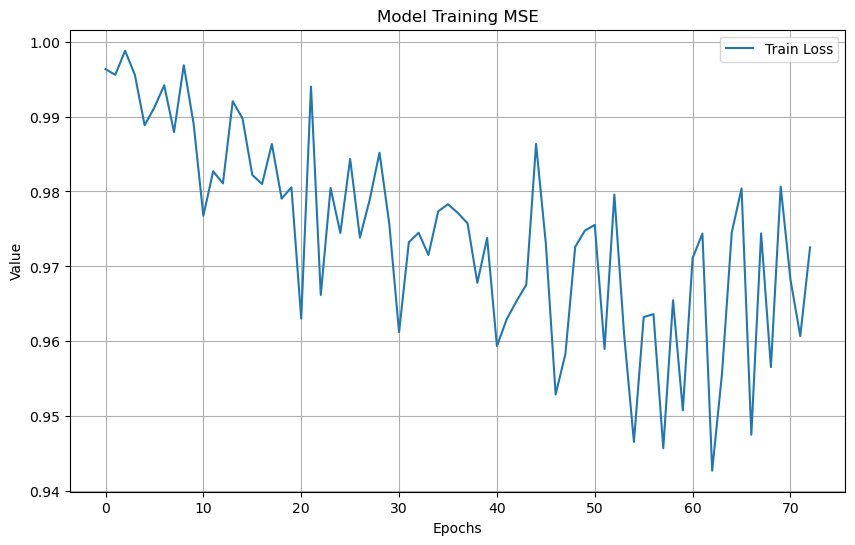

In [106]:
from keras.optimizers import Adam

# Model architecture
# model = Sequential()
# model.add(LSTM(256, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(64))
# model.add(Dropout(0.5))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse')

model.summary()

early_stopping = EarlyStopping(monitor='loss', patience=10)

# fit model

history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')


plt.title('Model Training MSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [107]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE", loss)

2/2 [==============================] - 1s 5ms/step - loss: 1.0430
MSE 1.042988896369934


In [108]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 0s/step
train_predict: (203, 1)
test_predict: (47, 1)


In [109]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_train, train_predict)
print("Train R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='Quebec: LSTM Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (203, 1)
y_train_scaled_inversed: (203, 1)
Train Mean Absolute Error: 10.240760518537316
Train Root Mean Squared Error: 12.802609605908774
Train R-squared: 0.043052588918959134


In [110]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test 
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_test, test_predict)
print("Test R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='Quebec: LSTM Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (47, 1)
y_test_scaled_inversed: (47, 1)
Test Mean Absolute Error: 8.363114766489216
Test Root Mean Squared Error: 9.720863116355765
Test R-squared: -0.0429888938723435


(2.6) Saskatchewan

In [111]:
resampled_SK = df[df['provincename'] == 'Saskatchewan']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_SK.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()

,Construction,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,1.955521,-12.126696,-21.643371,-16.911877,1.957775,-36.132356,0.071111,15.202222,17.271111,7.977778,0.511111,1.244444
1998-02-28,1.973519,-1.101262,-9.118113,-5.137857,6.325029,-21.979885,1.924444,7.760000,12.533333,8.222222,0.733333,1.111111
1998-03-31,1.815502,-0.781830,-12.051365,-6.422710,13.616929,-28.278167,0.448889,6.444444,10.053333,3.244444,0.155556,1.244444
1998-04-30,1.966323,13.740122,-0.558231,6.620447,25.554963,-8.135638,12.095652,0.854348,12.989130,0.000000,0.673913,1.326087
1998-05-31,1.895740,19.580392,4.087789,11.856558,27.889747,-4.563031,27.563043,0.145652,27.819565,0.000000,0.673913,1.282609


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

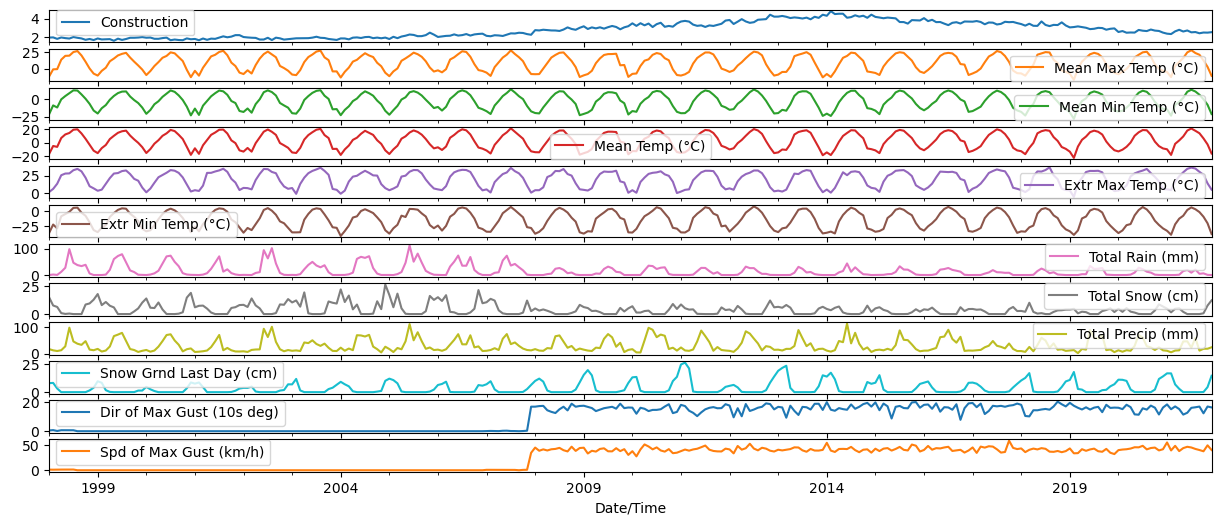

In [112]:
resampled[[
    'Construction',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [113]:
# split into train and test
train_end_date = '2014-12-31'
test_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[(resampled.index > train_end_date) & (resampled.index <= test_end_date)]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2014-12-31 00:00:00
(204, 12)
Test data:
2015-01-31 00:00:00
2018-12-31 00:00:00
(48, 12)


In [114]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[  1.9555207 -12.1266961 -21.6433711 -16.9118767   1.9577753 -36.1323565
   0.0711111  15.2022222  17.2711111   7.9777778   0.5111111   1.2444444]
(204, 12)
[  4.1950369  -6.6476672 -16.4938972 -11.5873559   6.8416841 -33.9810626
   0.1632653   5.1489796  13.3612245   8.3877551  19.5714286  43.2653061]
(48, 12)


In [115]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i - n_past,0])
    return np.array(dataX),np.array(dataY)    

In [116]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (203, 1, 11)
y_train: (203,)
After reshape:
X_train: (203, 11)
y_train: (203, 1)
Before reshape:
X_test: (47, 1, 11)
y_test: (47,)
After reshape:
X_test: (47, 11)
y_test: (47, 1)


In [117]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.6698373 -1.6490755 -1.66314   -1.5666557 -1.5650135 -0.7730117
  1.8995937 -0.5883483  0.8292041 -0.7658843 -0.7775881]
X_train_scaled: (203, 11)
y_train_scaled: [[-0.7650838]
 [-0.7444542]
 [-0.9255691]
 [-0.7527028]
 [-0.8336024]]
y_train_scaled: (203, 1)
X_test_scaled: [-1.3170818 -1.3160303 -1.3195223 -1.2290252 -1.4689573 -0.8956713
  1.164457  -0.7668967  1.1554668  1.2146221  0.1569657]
X_test_scaled: (47, 11)
y_test_scaled: [[2.1885934]
 [1.9342775]
 [1.6314428]
 [1.9132381]
 [1.7437825]]
y_test_scaled: (47, 1)


In [118]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (203, 11)
X_test: (47, 11)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 1, 128)            71680     
                                                                 
 dropout_13 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_18 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 203393 (794.50 KB)
Trainable params: 203393 (794.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean Sq

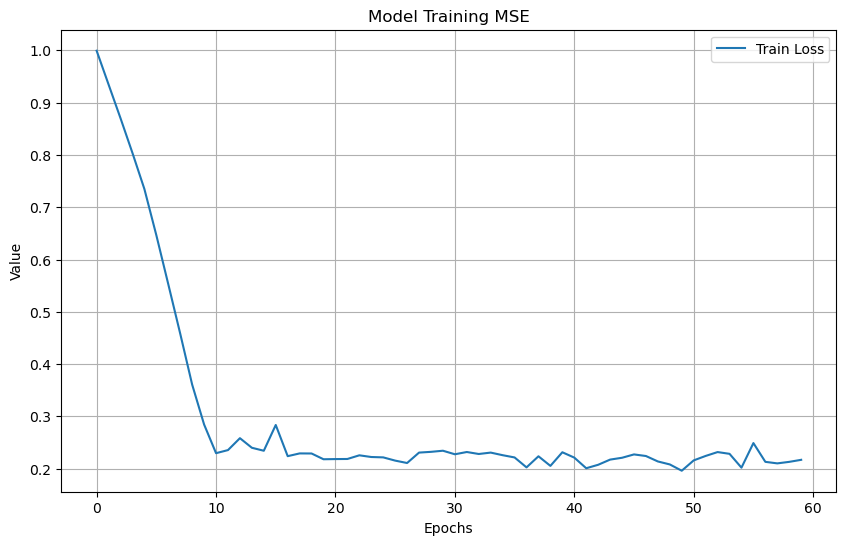

In [119]:
from keras.optimizers import Adam

# Model architecture
# model = Sequential()
# model.add(LSTM(256, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(64))
# model.add(Dropout(0.5))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
# model.add(Dropout(0.3))
model.add(Dropout(0.5))
model.add(LSTM(128))
# model.add(Dropout(0.3))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse')

model.summary()

early_stopping = EarlyStopping(monitor='loss', patience=10)

# fit model

history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')


plt.title('Model Training MSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [120]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE", loss)

2/2 [==============================] - 1s 11ms/step - loss: 1.0943
MSE 1.0942879915237427


In [121]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 16ms/step
train_predict: (203, 1)
test_predict: (47, 1)


In [122]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_train, train_predict)
print("Train R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='Saksatchewan: LSTM Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (203, 1)
y_train_scaled_inversed: (203, 1)
Train Mean Absolute Error: 0.29606404114337176
Train Root Mean Squared Error: 0.39082977430888344
Train R-squared: 0.7993351509833164


In [123]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test 
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# Calculate R-squared using sklearn's r2_score function
r2 = r2_score(y_test, test_predict)
print("Test R-squared:", r2)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='Saksatchewan: LSTM Prediction on Construction',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (47, 1)
y_test_scaled_inversed: (47, 1)
Test Mean Absolute Error: 0.21854655261264597
Test Root Mean Squared Error: 0.27035380589679897
Test R-squared: -0.09428804038718352
